# OpenStreetMap Sample Project 
## Data Wrangling with SQL and MongoDB
### *Elsa(Yishu) Wang*

Map Area: Around **Mountain View** and **Palo Alto**, CA, USA
https://mapzen.com/data/metro-extracts/your-extracts/0e538ffd2c40

[1.Problems Encountered in the Map](#1)
- [Over-abbreviated Street Names](#1.1)
- [Different Styles of Cities and State Names](#1.2)
- [Inconsistent second level `"k"`](#1.3)
- [Inconsistent postal codes](#1.4)

[2.Data Overview](#2)
- [SQL](#2.1)
- [MongoDB](#2.2)

[3.Other Ideas about the datasets](#3)

[3.Additional Ideas](#3)
- [Cross-field validating of `user` value](3.3)
- [Additional data exploration using SQL queries](*3.1)
- [Additional data exploration using MongoDB queries](*3.2)

## <a name="1"></a>1.Problems Encountered in the Map

After downloading the data around *Mountain View* and *Palo Alto* area, I run below code agains `data.py` to overview the fields and values:

In [1]:
import audit
from pprint import pprint
import xml.etree.cElementTree as ET

path = 'PaloAlto_MountainView_USA.osm'

Check the tags and their counts

In [4]:
tags = audit.get_tags(path)

3821393 tags found.
{'node': 1441121, 'nd': 1616553, 'bounds': 1, 'member': 8033, 'tag': 591472, 'relation': 1492, 'way': 162720, 'osm': 1}


In [16]:
for i, element in enumerate(audit.get_element(path, tags=("node"))):
    pprint(ET.tostring(element, encoding='utf-8'))
    if i == 1:
        break

'<node changeset="6776161" id="302863" lat="37.3769826" lon="-122.0677726" timestamp="2010-12-27T10:41:10Z" uid="14293" user="KindredCoda" version="4" />\n\t'
'<node changeset="6776161" id="302864" lat="37.3740667" lon="-122.0679336" timestamp="2010-12-27T10:39:22Z" uid="14293" user="KindredCoda" version="5" />\n\t'


In [17]:
for i, element in enumerate(audit.get_element(path, tags=("way"))):
    pprint(ET.tostring(element, encoding='utf-8'))
    if i == 1:
        break

'<way changeset="41607115" id="4304424" timestamp="2016-08-22T06:17:09Z" uid="933797" user="oba510" version="13">\n\t\t<nd ref="65495796" />\n\t\t<nd ref="280022084" />\n\t\t<nd ref="2425657373" />\n\t\t<nd ref="2425657370" />\n\t\t<nd ref="2425657372" />\n\t\t<nd ref="2425657371" />\n\t\t<nd ref="280022085" />\n\t\t<nd ref="3042421705" />\n\t\t<nd ref="26029084" />\n\t\t<tag k="lanes" v="1" />\n\t\t<tag k="layer" v="1" />\n\t\t<tag k="bridge" v="yes" />\n\t\t<tag k="oneway" v="yes" />\n\t\t<tag k="highway" v="secondary_link" />\n\t\t<tag k="sidewalk" v="no" />\n\t</way>\n\t'
'<way changeset="21185174" id="4311277" timestamp="2014-03-19T01:42:37Z" uid="123633" user="stevea" version="70">\n\t\t<nd ref="26028708" />\n\t\t<nd ref="2371003215" />\n\t\t<nd ref="26678537" />\n\t\t<tag k="ref" v="G6" />\n\t\t<tag k="name" v="Central Expressway" />\n\t\t<tag k="note" v="adding odbl tag to match split of way and remove tainted tags" />\n\t\t<tag k="lanes" v="2" />\n\t\t<tag k="oneway" v="yes" /

It seems the structures and tags of this file are similiar to the example.osm. Next, I check the value for `tag` in order to have a sense of the potential fields:

In [8]:
keys = audit.key_type(path)
print(keys['other'][0:10])
print(keys['problemchars'][0:10])
print(keys['lower'][0:10])
print(keys['lower_colon'][0:10])

['STATEFP', 'COUNTYFP', 'Tiger:MTFCC', 'STATEFP', 'COUNTYFP', 'Tiger:MTFCC', 'COUNTYFP', 'STATEFP', 'Tiger:MTFCC', 'STATEFP']
['Lydian Academy', 'addr.source:housenumber', 'addr.source:housenumber', 'addr.source:housenumber', 'addr.source:housenumber', 'addr.source:housenumber', 'addr.source:housenumber', 'addr.source:housenumber', 'addr.source:housenumber', 'addr.source:housenumber']
['ref', 'source', 'exit_to', 'highway', 'highway', 'source', 'highway', 'source', 'highway', 'ref']
['traffic_signals:sound', 'ref:left', 'ref:right', 'exit_to:left', 'exit_to:right', 'traffic_signals:direction', 'traffic_signals:sound', 'traffic_signals:sound', 'traffic_signals:sound', 'traffic_signals:sound']


Then I pick some values of k to check the details:

```
'addr:street' 'addr:postcode' 'addr:state' 
'addr:city' 'addr:county', 'AWATER'
```

In [13]:
audit.find_interest(path, 'addr:street', 10)

'<tag k="addr:street" v="South Fair Oaks Avenue" />\n\t\t'
'<tag k="addr:street" v="West El Camino Real" />\n\t\t'
'<tag k="addr:street" v="West El Camino Real" />'
'<tag k="addr:street" v="West El Camino Real" />\n\t\t'
'<tag k="addr:street" v="West El Camino Real" />\n\t\t'
'<tag k="addr:street" v="East El Camino Real" />\n\t\t'
'<tag k="addr:street" v="East Remington Drive" />\n\t\t'
'<tag k="addr:street" v="Hollenbeck Ave" />\n\t\t'
'<tag k="addr:street" v="West Evelyn Avenue" />\n\t\t'
'<tag k="addr:street" v="Lagunita Drive" />\n\t\t'


By looking some details of the choosen values of `k`, I noticed five main problems with the data, which I will discuss in the following order:

- Over-abbreviated Street Names:

```
<tag k="addr:street" v="Hollenbeck Ave">
<tag k="addr:street" v="Crane st">
```

- Different Styles of Cities and State Names:

```
"ca", "CA", "California"`
"157", 'Sunnyvale, CA'
'cupertino', 'San José'
```

- Inconsistent second level "k": `'AREAID', 'AWATER', 'Acres'`
- Inconsistent postal codes: `'CA 95014', 'CUPERTINO'`
```

### <a name="1.1"></a>Over-abbreviated Street Names

I use below function in `audit.py` to fix the over-abbreviated street names and the `mapping_streetname` dictionaries defined to according to the previous database exploring.

```python
def update_name(name, mapping=mapping_streetname):
    words = name.split()
    for w in range(len(words)):
        if words[w] in mapping:
            if words[w­].lower() not in ['suite', 'ste.', 'ste']:
                # For example, don't update 'Suite E' to 'Suite East'
                words[w] = mapping[words[w]]
                name = " ".join(words)
    return name
```

### <a name="1.2"></a>Different Styles of Cities and State Names

Luckily, there are only 7 cities and one state in choosen area, so I use the most common name to replace the inconsistent names of cities and state by below code:

```python
def update_city(name, mapping=mapping_cityandstatename):
    if name in mapping:
        name = mapping[name]
    return name
```

### <a name="1.3"></a>Inconsistent second level "k"

I solve it simply by using `.lower()` feature of `string` without difining new fuction.

### <a name="1.4"></a>Inconsistent postal codes

There're two problems of the postal codes. First, the code with abbreviation of california, and the second it uses city name not a postal code. In this step, I only fix the first problem by extracting the digital part of postal codes.

```python
error_post = re.compile(r'(^\D*)(\s)(\d.*)')

def update_post(post):
    if error_post.search(post):
        post = error_post.match(post)[3]
    return post
```

## <a name="2"></a>2.Data Overview

### <a name="2.1"></a>SQL

By modifying code from course for shaping data and combining above clean code, I executed `toCSV.py` to transform audited and cleaned data to `csv` files. Then, I imported these files into a local SQLite database with code below:

Import `.csv` data into `OSM.db`

```sql
.read data_wrangling_schema.sql
.import nodes.csv nodes
.import nodes_tags.csv nodes_tags
.import ways.csv ways
.import ways_tags.csv ways_tags
.import ways_nodes.csv ways_nodes
```

Connect to python `sqlite3` API

In [9]:
import sqlite3

In [10]:
db = sqlite3.connect("SQL/OSM.db")
c = db.cursor()

#### File sizes

```
PaloAlto_MountainView_USA.osm ... 308.4 MB
OSM.db .......................... 162.8 MB
nodes.csv ....................... 121.3 MB
nodes_tags.csv .................. 2.6 MB
ways.csv ........................ 9.8 MB
ways_tags.csv ................... 17.9 MB
ways_nodes.csv .................. 38.9 MB
```

#### Checkout quality of audited database

In [127]:
### check postcode
query = '''select tags.value, count(*) as count
           from (select * from nodes_tags
                 union all
                select * from ways_tags) tags
            where tags.key = 'postcode'
            group by tags.value
            order by count
            limit 10'''
c.execute(query)
c.fetchall()

[(u'30188', 1),
 (u'515', 1),
 (u'94025-1246', 1),
 (u'94035', 1),
 (u'94035-0016', 1),
 (u'9404', 1),
 (u'94043-3421', 1),
 (u'94084', 1),
 (u'94087-2248', 1),
 (u'94087\u200e', 1)]

In [131]:
### look over inconsistent data
query = '''select *
           from (select * from nodes_tags
                 union all
                select * from ways_tags) tags
            where tags.key='postcode'
            and (tags.value = '30188'
            or tags.value = '515')
            '''
c.execute(query)
c.fetchall()

[(112708857, u'postcode', u'515', u'addr'),
 (264858644, u'postcode', u'30188', u'addr')]

In [147]:
query = '''select * from ways_tags where id=112708857 or id=264858644 and type = 'addr'
'''
c.execute(query)
c.fetchall()

[(112708857, u'source', u'bing', u'regular'),
 (112708857, u'building', u'yes', u'regular'),
 (112708857, u'postcode', u'515', u'addr'),
 (112708857, u'housenumber', u'515', u'addr'),
 (264858644, u'city', u'Mountain View', u'addr'),
 (264858644, u'street', u'Escuela Avenue', u'addr'),
 (264858644, u'postcode', u'30188', u'addr'),
 (264858644, u'housenumber', u'586', u'addr')]

By searching online, I found that the address with '30188' postcode is a wrong, and the right postcode should be '94040'. Thus, I rectified the data with sqlite code below:

```sql
update ways_tags set value='94040' where (id=264858644 and key='postcode');
```

In [150]:
query = '''select * from ways_tags where id=112708857 or id=264858644 and type = 'addr'
'''
c.execute(query)
c.fetchall()

[(112708857, u'source', u'bing', u'regular'),
 (112708857, u'building', u'yes', u'regular'),
 (112708857, u'postcode', u'515', u'addr'),
 (112708857, u'housenumber', u'515', u'addr'),
 (264858644, u'city', u'Mountain View', u'addr'),
 (264858644, u'street', u'Escuela Avenue', u'addr'),
 (264858644, u'postcode', u'94040', u'addr'),
 (264858644, u'housenumber', u'586', u'addr')]

Because I couldn't find enough data to know where is the '515' address, I decide to leave it in database

#### Number of nodes

In [81]:
query = '''select count(*) from nodes'''
c.execute(query)
c.fetchall()[0][0]

1441121

#### Number of ways

In [82]:
query = '''select count(*) from ways'''
c.execute(query)
c.fetchall()[0][0]

162720

#### The distribution of version of nodes and ways

In [11]:
query = '''select e.version, count(*) as num
           from (select version from nodes union all
           select version from ways) e
           group by version
           order by num desc'''
c.execute(query)
version_dist = c.fetchall()

In [12]:
import pandas as pd    
df = pd.DataFrame(version_dist)
print df[:10]

    0        1
0   1  1025351
1   2   448139
2   3    78139
3   4    24148
4   5    10546
5   6     5840
6   7     3483
7   8     2086
8   9     1453
9  10      995


#### Top 10 nodes shared with ways

In [117]:
query = '''select ways_nodes.node_id, i.value, count(*) as num
           from ways_nodes
               join (select distinct(id), * from nodes_tags
           where nodes_tags.key = 'name') i
               on  ways_nodes.node_id = i.id
           group by ways_nodes.node_id
           order by num desc
           limit 10;'''
c.execute(query)
c.fetchall()

[(65560159, u'Escalon Ave ends here', 3),
 (3404870013, u'Calabazas Step-Up Jump', 3),
 (65387340, u'SR07', 2),
 (267888019, u'575', 2),
 (1389239042, u'Google Building 1965 lobby', 2),
 (2697101145, u'In Her Shoes', 2),
 (3176076002, u'RR03', 2),
 (3537007147, u'Loft House Leasing Office', 2),
 (4097853389, u'gate', 2),
 (4227636890, u'SR03', 2)]

#### The number of Library and University

I'd like to continue education in this area, so I'm interested in how many libraries and universities in this area. Library:

In [191]:
query = '''select count(*) from
           (select distinct(id) from nodes_tags where
           value='library')
        '''
c.execute(query)
c.fetchall()[0][0]

17

University:

In [161]:
query = '''select count(*) from
           (select distinct(id) from nodes_tags where
           value='university')
        '''
c.execute(query)
c.fetchall()[0][0]

2

### <a name="2.2"></a>MongoDB

Same as SQL, I executed `toJSON` for shaping the data into `JSON` file, and then I imported data into MongoDB

In [18]:
from pymongo import MongoClient, GEO2D
import toJSON

In [21]:
client = MongoClient('mongodb://localhost:27017/')
db = client.osm

In [13]:
osm_map = toJSON.process_map(path)
db.maps.insert_many(osm_map)

#### File size:
```
PaloAlto_MountainView_USA.osm ....... 308.4MB
PaloAlto_MountainView_USA.osm.json .. 345.7MB
```

#### Number of documents, nodes, ways and positions

In [6]:
db.maps.find().count()

1603841

In [15]:
db.maps.find({"type": "node"}).count()

1441121

In [16]:
db.maps.find({"type": "way"}).count()

162720

In [17]:
db.maps.find({"pos":{"$exists":1}}).count()

1441121

Also, I need to update the wrong postcode manually:

In [18]:
node = db.maps.find_one({"id":"264858644"})
node['address']['postcode'] = "94040"
db.maps.save(node)

/Users/ElsaW/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: save is deprecated. Use insert_one or replace_one instead
  This is separate from the ipykernel package so we can avoid doing imports until


ObjectId('596c18bb0a36f707180608a0')

#### Sort postcodes by counting

In [213]:
result = db.maps.aggregate([{"$match":{"address.postcode":{"$exists":1}}}, 
                   {"$group":{"_id":"$address.postcode", "count":{"$sum":1}}}, 
                   {"$sort":{"count":1}},
                   {"$limit":10}                  
                  ])

#### Sort street by counting

In [218]:
result = db.maps.aggregate([{"$match":{"address.street":{"$exists":1}}}, 
                   {"$group":{"_id":"$address.street", "count":{"$sum":1}}}, 
                   {"$sort":{"count":1}},
                   {"$limit":10}                  
                  ])

In [219]:
for i in result:
    pprint(i)

{u'_id': u'Chiala Lane', u'count': 1}
{u'_id': u'East Eaglewood Avenue', u'count': 1}
{u'_id': u'East Charleston Road APT 9', u'count': 1}
{u'_id': u'Leghorn Street #B', u'count': 1}
{u'_id': u'West Portola Avenue', u'count': 1}
{u'_id': u'Moraga Drive', u'count': 1}
{u'_id': u'Facebook Way', u'count': 1}
{u'_id': u'Bell Street', u'count': 1}
{u'_id': u'Tami Way', u'count': 1}
{u'_id': u'Whits Road', u'count': 1}


#### Sort city by counting

In [22]:
result = db.maps.aggregate([{"$match":{"address.city":{"$exists":1}}}, 
                   {"$group":{"_id":"$address.city", "count":{"$sum":1}}}, 
                   {"$sort":{"count":1}},
                   {"$limit":10}
                  ])

In [23]:
for i in result:
    pprint(i)

{u'_id': u'155', u'count': 1}
{u'_id': u'Santa Clara County', u'count': 1}
{u'_id': u'', u'count': 1}
{u'_id': u'157', u'count': 1}
{u'_id': u'South Mary Avenue', u'count': 1}
{u'_id': u'Moffett Field', u'count': 2}
{u'_id': u'Saratoga', u'count': 3}
{u'_id': u'San Jose', u'count': 3}
{u'_id': u'Artherton', u'count': 7}
{u'_id': u'Atherton', u'count': 10}


In [26]:
for find in db.maps.find({"address.city":{"$in": ["157", "155", ""]}}, {"address":1}):
    pprint(find)

{u'_id': ObjectId('596c18bb0a36f7071804f478'),
 u'address': {u'city': u'155', u'housenumber': u'155'}}
{u'_id': ObjectId('596c18bb0a36f70718050ff2'),
 u'address': {u'city': u'157', u'housenumber': u'157'}}
{u'_id': ObjectId('596c18bb0a36f7071805d382'), u'address': {u'city': u''}}


Even after auditing and cleaning, there're still a few of documents that cannot be corrected. Take account of limited number of these data, I decide to not do anything of them.

## <a name="3"></a>3.Additional Ideas

### <a name="3.3"></a>Cross-field validating of `user` value

The dataset could provide same information by different fields and they could use to cross-validating the consistency and accuracy of the dataset. Here I'd like to use `user` and `uid` fields to improve the quality of data.

#### Imputing missing data

During auditing, I found some value of users are empty, and I set those users' values to 'NA'. Becasue the dataset has both `uid` and `user`, It is possible to impute the `user` if they have `uid` value.

In [32]:
Nas = db.maps.find({"created.user": "NA"},{"created.uid":1, "_id":0, "created.user":1})

In [33]:
for na in Nas:
    pprint(na)

{u'created': {u'uid': u'NA', u'user': u'NA'}}
{u'created': {u'uid': u'NA', u'user': u'NA'}}
{u'created': {u'uid': u'NA', u'user': u'NA'}}
{u'created': {u'uid': u'NA', u'user': u'NA'}}


Oops, the query result is negative. It seems we can not correct those missing value from inside of this database, but it could be a good try to audit data for a larger scale.

#### Consistent of `user` and `uid`

According to *OpenStreetMap*, each `uid` should be responded to one and only one `user`, which means the number of unique `user` should be equal to the number of `uid`.

##### Inconsistent user and uid

In [17]:
len(db.maps.distinct("created.user"))

1076

In [35]:
len(db.maps.distinct("created.uid"))

1075

Interstingly, there is one more `user` name than `uid`. It breaks the consistency of `uid` and `user`. Let we find what happend:

In [50]:
result = db.maps.aggregate([
    {"$group": {"_id": "$created.uid",
                "count":{"$sum": 1},
                "users": {"$addToSet": "$created.user"}}},
    {"$project": {"_id":1,
                  "count":1,
                  "users": 1,
                  "size of name": {"$size": "$users"}}},
    {"$match": {"size of name": {"$gt": 1}}}   
])

In [51]:
for r in result:
    pprint(r)

{u'_id': u'6022281',
 u'count': 70,
 u'size of name': 2,
 u'users': [u'Dana Bringas', u'Dana_Bringas']}


In [52]:
db.maps.find({"created.user":"Dana Bringas"}).count()

19

In [53]:
db.maps.find({"created.user":"Dana_Bringas"}).count()

51

There're different rules for blank between first and last name. Let we fix it:

In [54]:
names = db.maps.find({"created.user":"Dana_Bringas"})
for name in names:
    name['created']['user'] = "Dana Bringas"
    db.maps.save(name)

/Users/ElsaW/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: save is deprecated. Use insert_one or replace_one instead
  after removing the cwd from sys.path.


In [56]:
len(db.maps.distinct("created.user"))

1075

#### Discussion

For the situation like above, there could be two solutions:

- remove missing or inconsistent values
- fix them via cross-validating from inside or outside database

First solution is easy and fast. Generally, for a big enough dataset, to remove small parts of data will not affect its accuracy to analysis. However, if missing and inconsistent values take too much account of the dataset, we must be really careful for making *delete* decision, because the data quality will be feasible by removing large parts of data.

Second solution seems to be safer than the first one. It could be keep the total volumn of dataset and set values for each missing data. However, two possible disadvantages are still there. It's hard to ensure the data quality after imputing or correcting. Some operations to *fix* data actually mess up data. Also, if need-to-fix data is too large, the whole process will take much time and energy, which may cause the increase of cost.

Thus, my suggestion for handling the missing and inconsistent data is that to balance the data size and cost. At this project, I chose to fix the data for two reasons: fist, the number of data is not too small to ignore it, there are 70 posts about the inconsistent names; second, it's relatively easy to fix it-only one name needed to update. However, the anticipated issus of this operation should be remebered. I fixed the name under the assumption that two user names are the same one, but what if they actually two users, and the system assigned the same uid for them mistakely?

### <a name="3.1"></a>Additional data exploration using SQL queries

The OpenStreetMaps are updated by users manualy, which means that the version times show the users' concentrations on the area. To explore the `version` could time the users' behaviour when they edit the OSM online. The larger `version` value implies the high attention, vice versa.

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline 

In [14]:
df = df.rename(index=str, columns={0: "version", 1: "count"})
df = df.set_index('version')

In [15]:
df[:10]

,count
version,
1,1025351
2,448139
3,78139
4,24148
5,10546
6,5840
7,3483
8,2086
9,1453


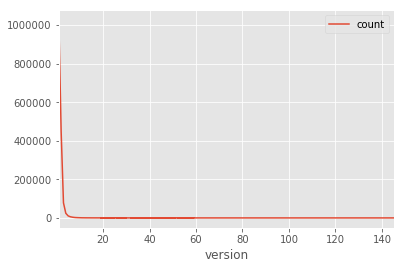

In [27]:
df.plot()

Most of (over 63%) nodes and ways at this area are just edited once, 28% of nodes and ways are updated once after first inputing, only about 5% nodes and ways are updated twice after first inputing. This result implies that the data of OSM in this area might be out of date to some extent.

Also, some nodes and ways show the unusal high version, such as 83 times updated and 145 times updated. Let we explore them and try to find the reason by the data.

In [291]:
query = '''select *
           from ways
            where version = 83 or version = 145
            '''
c.execute(query)
c.fetchall()

[(4786675, u'n76', 318696, 145, 17945349, u'2013-09-20T19:04:10Z'),
 (4809373, u'nikhilprabhakar', 2835928, 83, 38445809, u'2016-04-10T09:12:58Z')]

In [28]:
query = '''select *
           from ways_tags
           where id = 4786675 or id = 4809373
           limit 5
        '''
c.execute(query)
c.fetchall()

[(4786675, u'hgv', u'designated', u'regular'),
 (4786675, u'ref', u'I 280', u'regular'),
 (4786675, u'foot', u'no', u'regular'),
 (4786675, u'name', u'Junipero Serra Freeway', u'regular'),
 (4786675, u'horse', u'no', u'regular')]

The exploration shows that two unusual updated points are road type ways. Their high number of number may be caused by road construction or traffic rules changes frequently...

##### Top 10 appearing amenties

In [306]:
query = '''select value, count(*) as num
           from nodes_tags
            where key = "amenity"
            group by value
            order by num desc
            limit 10;
            '''
c.execute(query)
c.fetchall()

[(u'restaurant', 388),
 (u'bicycle_parking', 356),
 (u'bench', 302),
 (u'post_box', 191),
 (u'cafe', 151),
 (u'fast_food', 126),
 (u'drinking_water', 110),
 (u'parking_entrance', 75),
 (u'toilets', 74),
 (u'atm', 55)]

##### Top 10 most popular type of cafe

In [32]:
query = '''select nodes_tags.value, count(*) as num
           from nodes_tags
                join (select distinct(id) from nodes_tags where value="cafe") i
                on nodes_tags.id= i.id
            where nodes_tags.key="cuisine"
            group by value
            order by num desc
            limit 10;
            '''
c.execute(query)
c.fetchall()

[(u'coffee_shop', 24),
 (u'american', 4),
 (u'bubble_tea', 3),
 (u'tea', 3),
 (u'bagels', 2),
 (u'regional', 2),
 (u'sandwich', 2),
 (u'Japanese', 1),
 (u'Mexican, salads, sandwiches, gelato, frittata, cakes', 1),
 (u'bagel', 1)]

### <a name="3.2"></a>Additional data exploration using MongoDB queries


In [35]:
## Create geospatial indexing
db.maps.create_index([("pos", GEO2D)])

u'pos_2d'

Well, I'm planing to visit Google at Mountain View, so I'd like to explore the Google area and make a *perfect plan* before I leave :)

In [332]:
### Find Google GPS location
db.maps.find_one({"name": "Google Visitor Center"},{"name": 1, "pos": 1, "_id": 0})

{u'name': u'Google Visitor Center', u'pos': [37.4194653, -122.0875371]}

##### Top 5 neareast restaurants around Google

In [36]:
result = db.maps.aggregate(
[{"$geoNear":{
    "near":[37.4194653, -122.0875371],
    "distanceField": "distance",
    "maxDistance": 1000,
    "query": {"amenity": "restaurant"},
    }},
 {"$project": {"phone":1, "name" :1, "_id": 0, "distance":1, "cuisine":1, "address": 1, }},
 {"$sort": {"distance": 1}},
 {"$limit":5}
])

In [37]:
for i in result:
    pprint(i)

{u'address': {u'city': u'Mountain View',
              u'housenumber': u'2025',
              u'postcode': u'94043',
              u'state': u'California',
              u'street': u'Garcia Avenue'},
 u'distance': 0.006216221875054424,
 u'name': u'Crave'}
{u'distance': 0.008263659253622616, u'name': u'Evolution Cafe'}
{u'cuisine': u'indian;pakistani',
 u'distance': 0.00873932670747542,
 u'name': u'Zareen\u2019s'}
{u'address': {u'city': u'Mountain View',
              u'housenumber': u'2430',
              u'postcode': u'94043',
              u'state': u'California',
              u'street': u'East Charleston Road'},
 u'cuisine': u'barbecue',
 u'distance': 0.009234248188122927,
 u'name': u'L&L Hawaiian Barbecue'}
{u'address': {u'city': u'Mountain View',
              u'housenumber': u'1390',
              u'postcode': u'94043',
              u'state': u'California',
              u'street': u'Pear Avenue'},
 u'cuisine': u'italian',
 u'distance': 0.010523310430669652,
 u'name': u'Cucina 

##### Check most popular cuisine wihtin 5km around Google

In [410]:
result = db.maps.aggregate(
[{"$geoNear":{
    "near":[37.4194653, -122.0875371],
    "distanceField": "distance",
    "maxDistance": 5000,
    "query": {"amenity": "restaurant"}
    }},
 {"$group": {"_id":"$cuisine", "count":{"$sum":1}}},
 {"$sort": {"count": -1}},
 {"$limit": 10}
])

In [411]:
for i in result:
    pprint(i)

{u'_id': None, u'count': 17}
{u'_id': u'japanese', u'count': 12}
{u'_id': u'pizza', u'count': 9}
{u'_id': u'mexican', u'count': 8}
{u'_id': u'chinese', u'count': 7}
{u'_id': u'vietnamese', u'count': 5}
{u'_id': u'indian', u'count': 5}
{u'_id': u'american', u'count': 4}
{u'_id': u'burger', u'count': 3}
{u'_id': u'asian', u'count': 3}


## Conclusion

This project simply overviewed the aspects of `OpenStreetMap` data around **Mountain View** and **Palo Alto** and checked the user updated behaviours wiht `SQL` and eating condition near Google with `MongoDB`.